In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

# get all ground truth dataframe
gt_df = pd.DataFrame()
for (collection_name, phone_name), df in tqdm(train_df.groupby(["collectionName", "phoneName"])):
    path = data_dir / f"train/{collection_name}/{phone_name}/ground_truth.csv"
    df = pd.read_csv(path)  
    gt_df = pd.concat([gt_df, df]).reset_index(drop=True)   
gt_df.head()

  0%|          | 0/73 [00:00<?, ?it/s]

collectionName phoneName  millisSinceGpsEpoch     latDeg      lngDeg  \
0  2020-05-14-US-MTV-1    Pixel4        1273529463442  37.423576 -122.094132   
1  2020-05-14-US-MTV-1    Pixel4        1273529464442  37.423576 -122.094132   
2  2020-05-14-US-MTV-1    Pixel4        1273529465442  37.423576 -122.094132   
3  2020-05-14-US-MTV-1    Pixel4        1273529466442  37.423576 -122.094132   
4  2020-05-14-US-MTV-1    Pixel4        1273529467442  37.423576 -122.094132   

   heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  hDop  vDop  speedMps  \
0                       33.21                    551.44   1.1   0.0       0.0   
1                       33.21                    552.44   1.1   0.0       0.0   
2                       33.21                    553.44   1.1   0.0       0.0   
3                       33.20                    554.44   1.1   0.0       0.0   
4                       33.20                    555.44   1.1   0.0       0.0   

   courseDegree  
0          12.7  
1          12.7  
2          12.7  
3          12.7  
4          12.7

# Target Place

In [2]:
# target_collection = '2021-04-29-US-SJC-2'
target_collection = '2020-05-14-US-MTV-1'
target_gt_df = gt_df[gt_df["collectionName"]==target_collection].reset_index(drop=True)
target_collection

'2020-05-14-US-MTV-1'

In [3]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd
import folium

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
# change pd.DataFrame -> gpd.GeoDataFrame
target_gt_df["geometry"] = [Point(p) for p in target_gt_df[["lngDeg", "latDeg"]].to_numpy()]
target_gt_gdf = gpd.GeoDataFrame(target_gt_df, geometry=target_gt_df["geometry"])
target_gt_gdf.head(5)


collectionName phoneName  millisSinceGpsEpoch     latDeg      lngDeg  \
0  2020-05-14-US-MTV-1    Pixel4        1273529463442  37.423576 -122.094132   
1  2020-05-14-US-MTV-1    Pixel4        1273529464442  37.423576 -122.094132   
2  2020-05-14-US-MTV-1    Pixel4        1273529465442  37.423576 -122.094132   
3  2020-05-14-US-MTV-1    Pixel4        1273529466442  37.423576 -122.094132   
4  2020-05-14-US-MTV-1    Pixel4        1273529467442  37.423576 -122.094132   

   heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  hDop  vDop  speedMps  \
0                       33.21                    551.44   1.1   0.0       0.0   
1                       33.21                    552.44   1.1   0.0       0.0   
2                       33.21                    553.44   1.1   0.0       0.0   
3                       33.20                    554.44   1.1   0.0       0.0   
4                       33.20                    555.44   1.1   0.0       0.0   

   courseDegree                     geometry  
0          12.7  POINT (-122.09413 37.42358)  
1          12.7  POINT (-122.09413 37.42358)  
2          12.7  POINT (-122.09413 37.42358)  
3          12.7  POINT (-122.09413 37.42358)  
4          12.7  POINT (-122.09413 37.42358)

<AxesSubplot:>

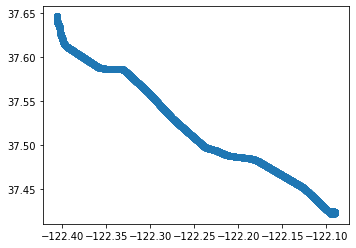

In [5]:
target_gt_gdf.plot()

In [6]:
# get road data from open street map by osmnx
offset = 0.1**5
bbox = target_gt_gdf.bounds + [-offset, -offset, offset, offset]
east = bbox["minx"].min()
west = bbox["maxx"].max()
south = bbox["miny"].min()
north = bbox["maxy"].max()
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

In [7]:
# ox.folium.plot_graph_folium(G)

In [8]:
nodes, edges = momepy.nx_to_gdf(G)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/momepy/utils.py:418: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


In [9]:
nodes.head()

y           x   ref            highway  street_count  nodeID  \
0  37.560184 -122.302578  414B  motorway_junction             3       0   
1  37.423517 -122.101489   NaN                NaN             3       1   
2  37.481955 -122.177346   406  motorway_junction             3       2   
3  37.483360 -122.180471   NaN                NaN             3       3   
4  37.484536 -122.184170   NaN                NaN             3       4   

                      geometry  
0  POINT (-122.30258 37.56018)  
1  POINT (-122.10149 37.42352)  
2  POINT (-122.17735 37.48195)  
3  POINT (-122.18047 37.48336)  
4  POINT (-122.18417 37.48454)

In [10]:
edges.head()

osmid  oneway         lanes     ref  \
0                                    24054675    True             4  US 101   
1                        [512386104, 8920615]    True             3     NaN   
2                                    96749331   False             3     NaN   
3  [385243928, 392651465, 679545026, 8924237]    True  [3, 4, 2, 1]     NaN   
4                                   395436903    True             4  US 101   

               name        highway maxspeed    length  \
0  Bayshore Freeway       motorway   65 mph  1327.778   
1               NaN  motorway_link   65 mph   321.491   
2  San Antonio Road        primary   35 mph   321.613   
3               NaN  motorway_link   45 mph   377.841   
4  Bayshore Freeway       motorway   65 mph   317.275   

                                            geometry bridge tunnel junction  \
0  LINESTRING (-122.30258 37.56018, -122.30222 37...    NaN    NaN      NaN   
1  LINESTRING (-122.30258 37.56018, -122.30161 37...    NaN    NaN      NaN   
2  LINESTRING (-122.10149 37.42352, -122.10136 37...    NaN    NaN      NaN   
3  LINESTRING (-122.17735 37.48195, -122.17752 37...    NaN    NaN      NaN   
4  LINESTRING (-122.17735 37.48195, -122.17744 37...    NaN    NaN      NaN   

  access  node_start  node_end  
0    NaN           0     11147  
1    NaN           0       487  
2    NaN           1      1700  
3    NaN           2       715  
4    NaN           2         3

<AxesSubplot:>

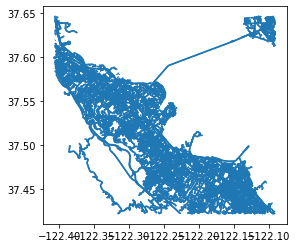

In [11]:
edges.plot()

# only the relevent roads

In [12]:
edges = edges.dropna(subset=["geometry"]).reset_index(drop=True)
hits = bbox.apply(lambda row: list(edges.sindex.intersection(row)), axis=1)
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(edges.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(target_gt_gdf.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=target_gt_gdf.crs)

In [13]:
tmp.head()

pt_idx   line_i                osmid  oneway lanes  ref  \
0       0  17585.0  [8960176, 74988749]   False     2  NaN   
1       0  17579.0  [8960176, 74988749]   False     2  NaN   
2       1  17585.0  [8960176, 74988749]   False     2  NaN   
3       1  17579.0  [8960176, 74988749]   False     2  NaN   
4       2  17585.0  [8960176, 74988749]   False     2  NaN   

                               name                   highway maxspeed  \
0  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]      NaN   
1  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]      NaN   
2  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]      NaN   
3  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]      NaN   
4  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]      NaN   

     length                                           geometry bridge tunnel  \
0  1003.156  LINESTRING (-122.09941 37.42748, -122.09919 37...    NaN    NaN   
1  1003.156  LINESTRING (-122.09320 37.42530, -122.09327 37...    NaN    NaN   
2  1003.156  LINESTRING (-122.09941 37.42748, -122.09919 37...    NaN    NaN   
3  1003.156  LINESTRING (-122.09320 37.42530, -122.09327 37...    NaN    NaN   
4  1003.156  LINESTRING (-122.09941 37.42748, -122.09919 37...    NaN    NaN   

  junction access  node_start  node_end                        point  
0      NaN    NaN        8864      8862  POINT (-122.09413 37.42358)  
1      NaN    NaN        8862      8864  POINT (-122.09413 37.42358)  
2      NaN    NaN        8864      8862  POINT (-122.09413 37.42358)  
3      NaN    NaN        8862      8864  POINT (-122.09413 37.42358)  
4      NaN    NaN        8864      8862  POINT (-122.09413 37.42358)

# Find closest road

In [14]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
tolerance = 0.0005  
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest = closest.drop_duplicates("line_i").reset_index(drop=True)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  """Entry point for launching an IPython kernel.


<AxesSubplot:>

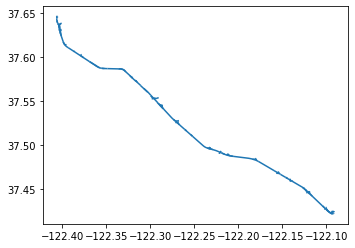

In [15]:
closest.plot()

In [16]:
closest.head()

line_i                              osmid  oneway   lanes   ref  \
0  17579.0                [8960176, 74988749]   False       2  None   
1  17585.0                [8960176, 74988749]   False       2  None   
2  17581.0  [691243285, 699515188, 699515189]   False  [2, 3]  None   
3  17578.0  [699515189, 699515188, 691243285]   False  [2, 3]  None   
4  19028.0                          394368090    True       1  None   

                               name                   highway maxspeed  \
0  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]     None   
1  [Bayshore Parkway, Salado Drive]  [tertiary, unclassified]     None   
2                     Garcia Avenue              unclassified   35 mph   
3                     Garcia Avenue              unclassified   35 mph   
4              Amphitheatre Parkway             motorway_link   35 mph   

     length                                           geometry bridge tunnel  \
0  1003.156  LINESTRING (-122.09320 37.42530, -122.09327 37...   None   None   
1  1003.156  LINESTRING (-122.09941 37.42748, -122.09919 37...   None   None   
2   215.346  LINESTRING (-122.09320 37.42530, -122.09318 37...   None   None   
3   215.346  LINESTRING (-122.09095 37.42458, -122.09113 37...   None   None   
4   108.946  LINESTRING (-122.09121 37.42329, -122.09137 37...   None   None   

  junction access  node_start  node_end                        point  \
0     None   None        8862      8864  POINT (-122.09405 37.42373)   
1     None   None        8864      8862  POINT (-122.09401 37.42372)   
2     None   None        8862      8861  POINT (-122.09319 37.42523)   
3     None   None        8861      8862  POINT (-122.09313 37.42522)   
4     None   None        9583      9582  POINT (-122.09130 37.42330)   

   snap_dist  
0   0.000488  
1   0.000450  
2   0.000062  
3   0.000044  
4   0.000045

In [17]:
closest.shape

(115, 18)

# Generate road points

In [18]:
line_points_list = []
split = 50  # param: number of split in each LineString
for dist in range(0, split, 1):
    dist = dist/split
    line_points = closest["geometry"].interpolate(dist, normalized=True)
    line_points_list.append(line_points)
line_points = pd.concat(line_points_list).reset_index(drop=True)
line_points = line_points.reset_index().rename(columns={0:"geometry"})
line_points["lngDeg"] = line_points["geometry"].x
line_points["latDeg"] = line_points["geometry"].y

In [19]:
fig = px.scatter_mapbox(line_points,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",

                    zoom=15,
                    center={"lat":37.33351, "lon":-121.8906},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()